<a href="https://colab.research.google.com/github/VictorNigretto/ProjetLong/blob/main/Segmentation_non_supervis%C3%A9e_%22facile%22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Dans ce colab, je vais essayer de réaliser une segmentation non supervisée, pour segmenter le sol, des pierres, des arbres et des lacs sur des images de forêts

In [33]:
import os
import shutil
from tensorflow.python.client import device_lib
import keras
from keras import layers, models, optimizers
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers import Dense, Flatten, Dropout, Input
from keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.applications import EfficientNetB7, ResNet50
from keras.preprocessing import image
from keras.models import Model
from keras.callbacks import LearningRateScheduler
import pandas as pd
import tensorflow as tf
import numpy as np
from keras.preprocessing.image import load_img
from PIL import Image
from keras.utils import to_categorical 
import cv2
from google.colab.patches import cv2_imshow

import matplotlib.pyplot as plt

Récupération d'une image de test

In [6]:
from google.colab import files
uploaded = files.upload()

Saving 100_0001_0116.JPG to 100_0001_0116.JPG


On vérifie la taille de l'image et on l'affiche

In [7]:
import random
from keras.preprocessing.image import load_img

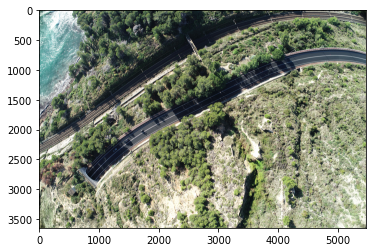

Image shape :  (3648, 5472, 3)


In [66]:
image = load_img('100_0001_0116.JPG')
plt.imshow(image)
plt.show()
print("Image shape : ", np.shape(image))
image = np.array(image)

In [67]:
from skimage.transform import rescale, resize, downscale_local_mean

image = rescale(image, 0.10, multichannel=True, anti_aliasing=True)

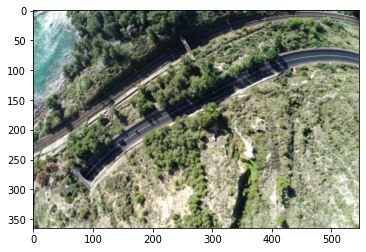

image reshaped shape :  (365, 547, 3)


In [68]:
plt.imshow(image)
plt.show()
print("image reshaped shape : ", np.shape(image))

On va tenter une segmentation en superpixels avec Sklearn

Quickshift number of segments: 376


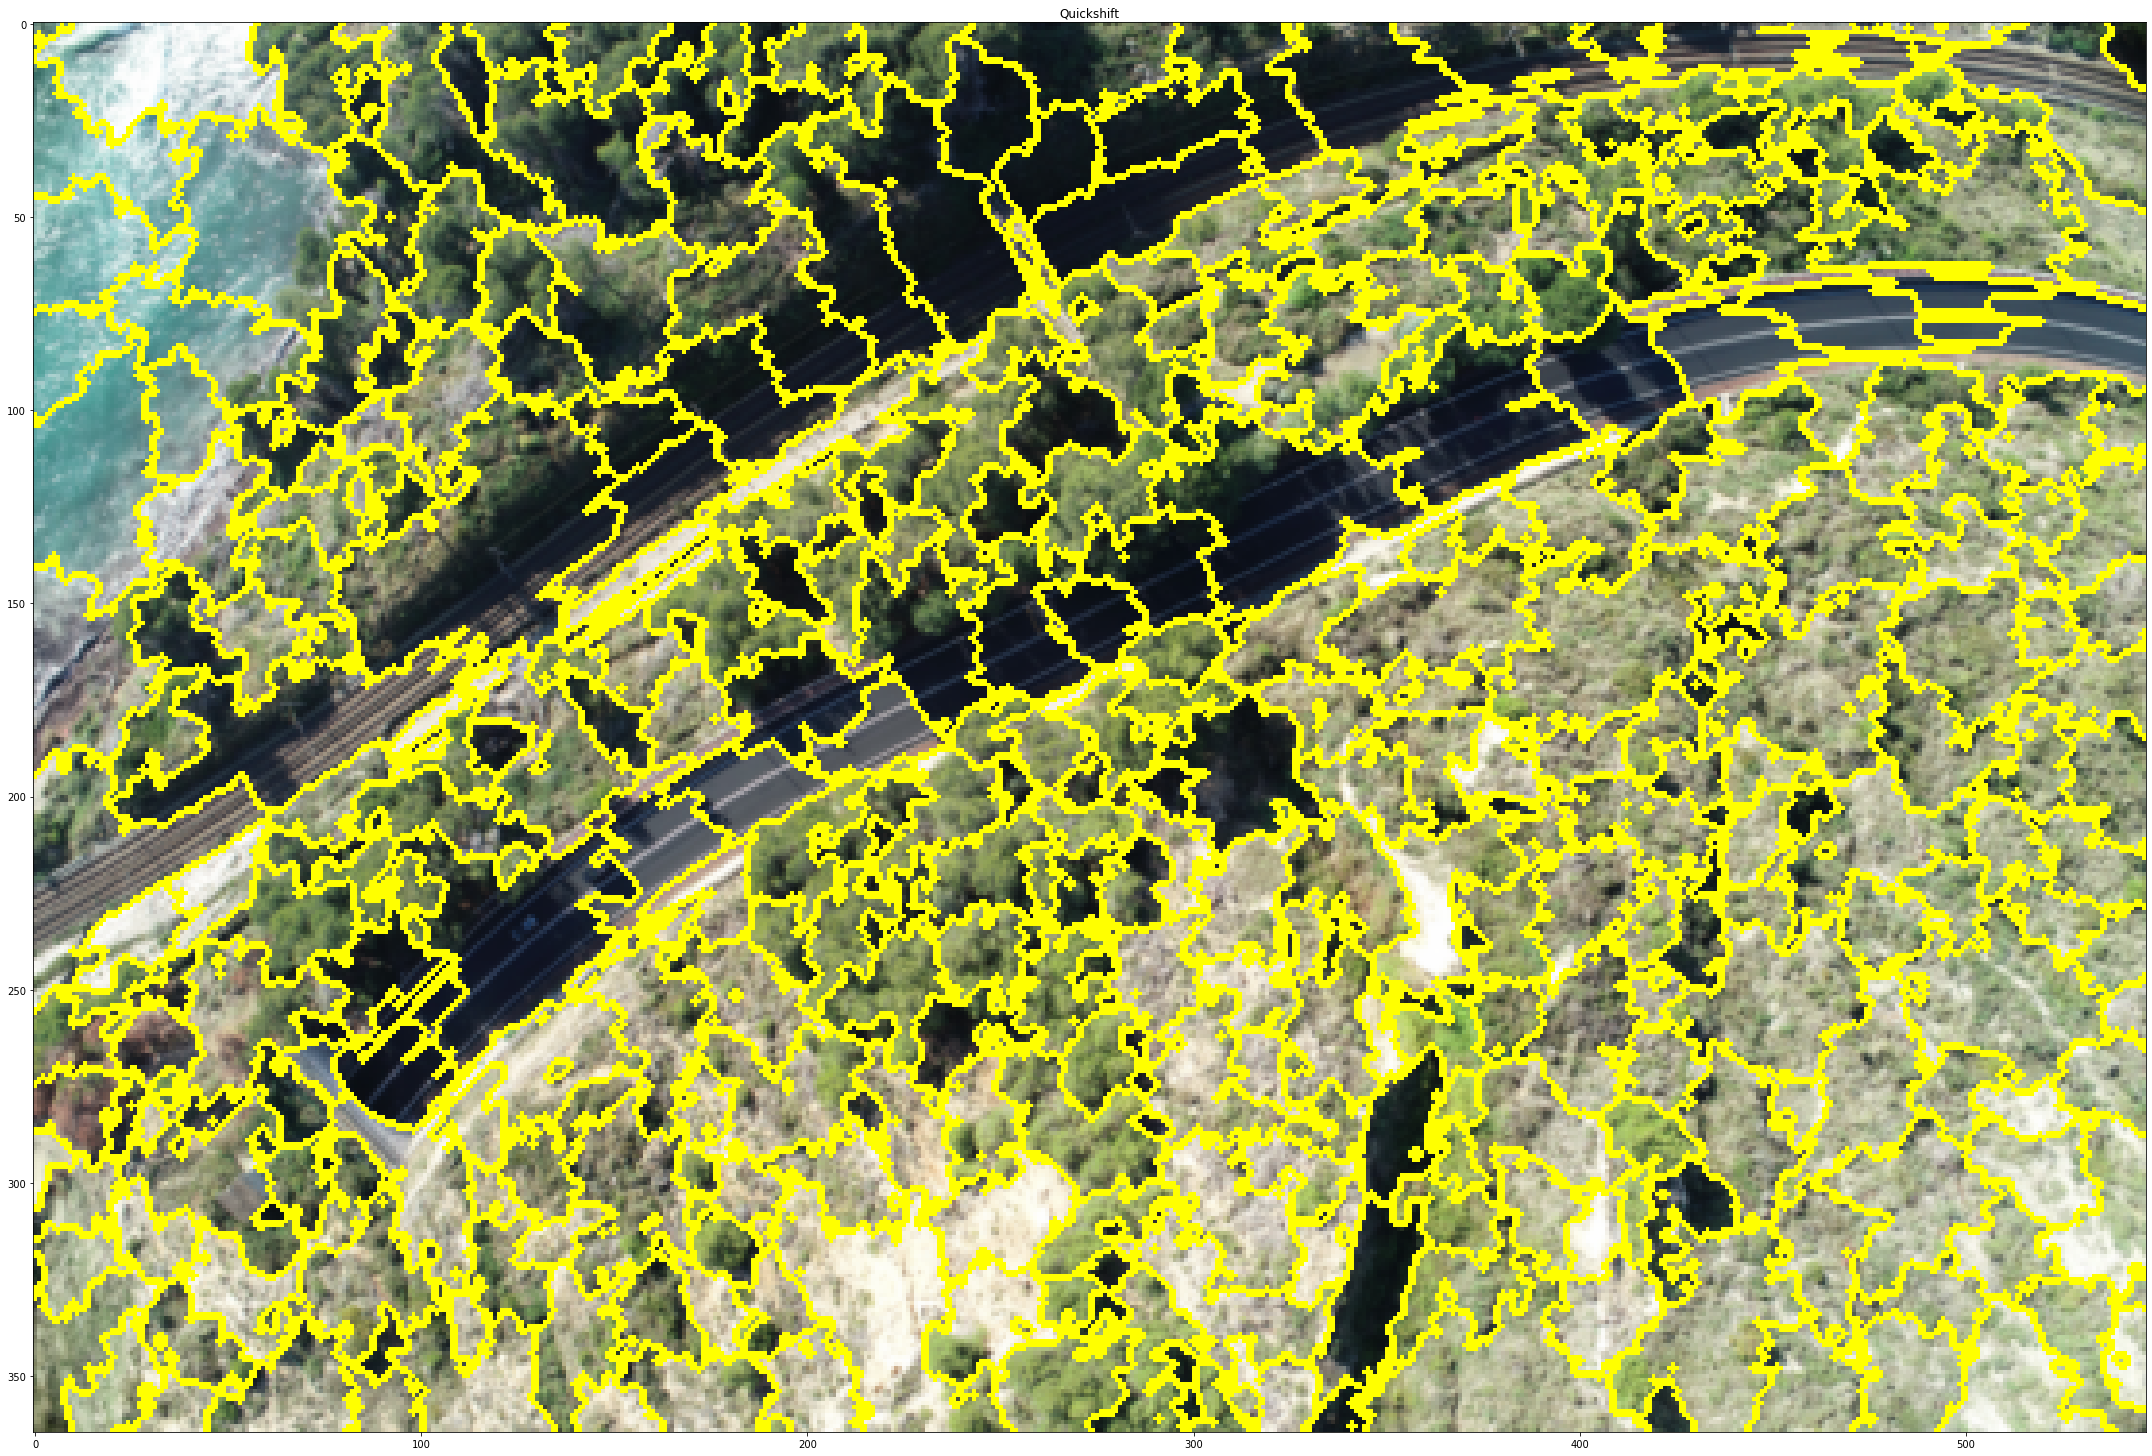

In [85]:
from skimage.filters import sobel
from skimage.segmentation import felzenszwalb, slic, quickshift, watershed
from skimage.segmentation import mark_boundaries
from skimage.util import img_as_float
from skimage.color import rgb2gray

img = img_as_float(image)
segments_quick = quickshift(img, kernel_size=3, max_dist=20, ratio=0.5)

#gradient = sobel(rgb2gray(img))
#segments_watershed = watershed(gradient, markers=250, compactness=0.001)

print(f"Quickshift number of segments: {len(np.unique(segments_quick))}")
#print(f"Compact Watershed number of segments: {len(np.unique(segments_watershed))}")
fig, ax = plt.subplots(1, 1, figsize=(30, 30), sharex=True, sharey=True)


ax.imshow(mark_boundaries(img, segments_quick))
ax.set_title('Quickshift')

#ax[1].imshow(mark_boundaries(img, segments_watershed))
#ax[1].set_title('Compact watershed')


plt.tight_layout()
plt.show()

Calcul de la couleur moyenne sur chaque segment

In [86]:
img_reshaped = image.reshape((image.shape[0]*image.shape[1],image.shape[2]))
print("img reshaped shape", np.shape(img_reshaped))

segments_reshaped = np.reshape(segments_quick, -1)    
print("segment reshaped shape", np.shape(segments_reshaped))

unique_segments = np.unique(segments_reshaped)
print("unique segment shape", np.shape(unique_segments))
img_temp = np.zeros(img_reshaped.shape)

for i in unique_segments:
  loc=np.where(segments_reshaped==i)[0]
  #print(loc)
  means=np.mean(img_reshaped[loc, :], axis=0)
  img_temp[loc, :] = means

new_img = np.reshape(img_temp, [image.shape[0], image.shape[1], image.shape[2]])


img reshaped shape (199655, 3)
segment reshaped shape (199655,)
unique segment shape (376,)


In [87]:
print(img[20, 0, 0], new_img[20, 0, 0])

0.3463229708501912 0.5724959971674555


On obtient une nouvelle image de couleur moyenne

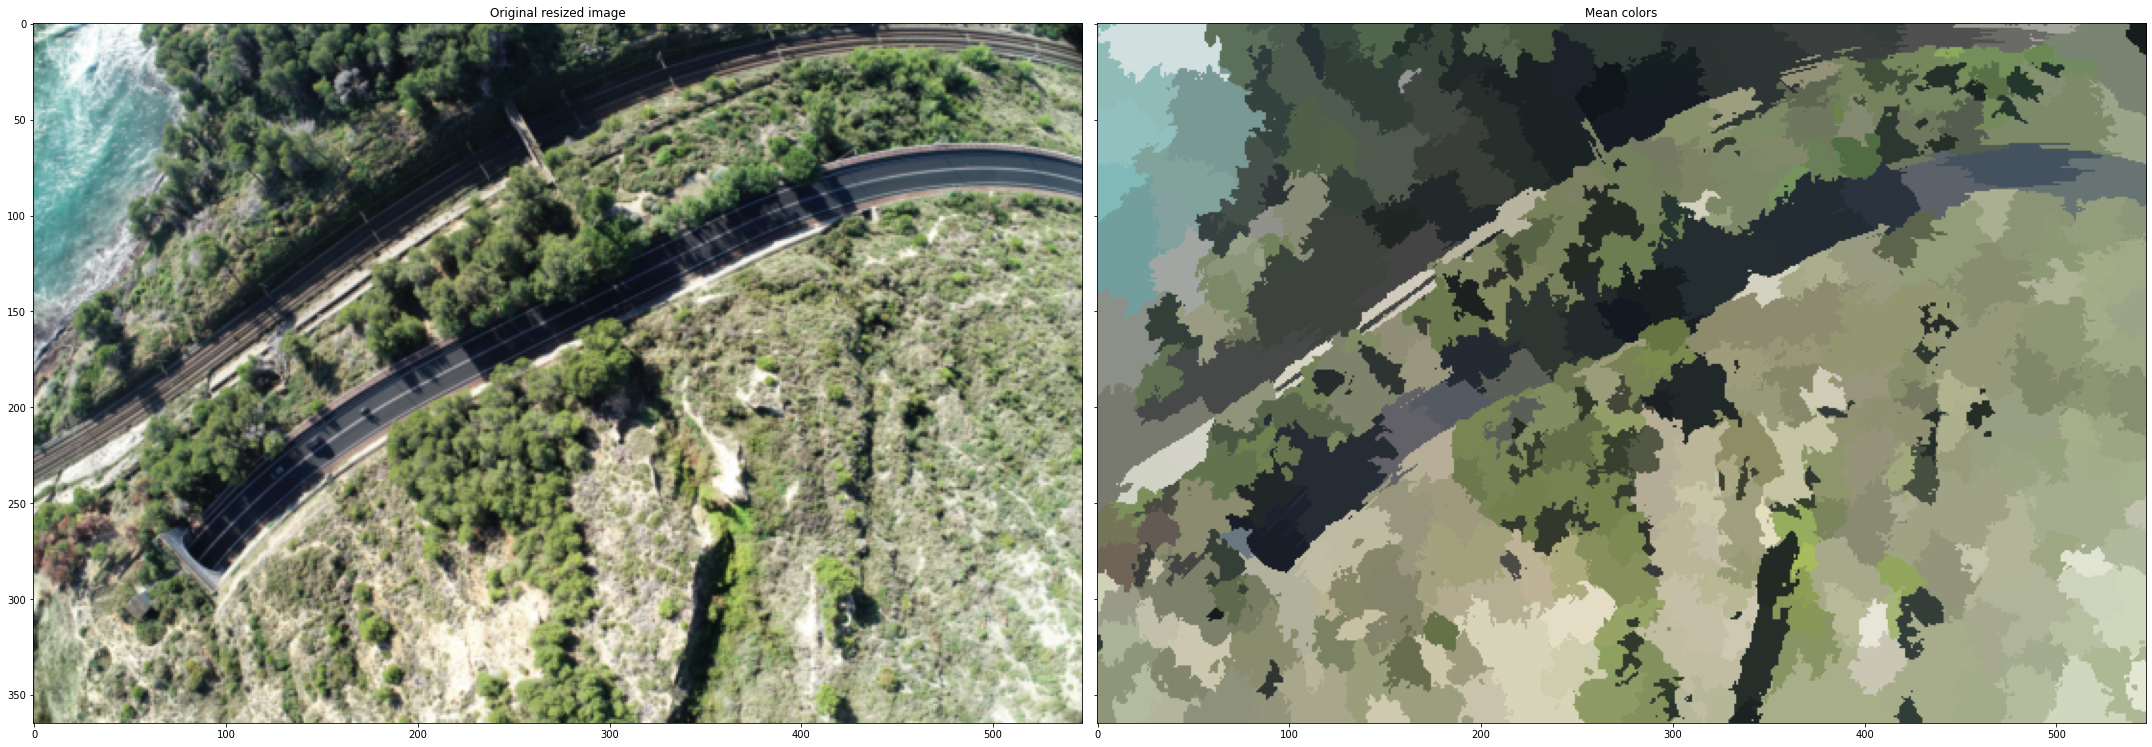

In [88]:
new_img = img_as_float(new_img)

fig, ax = plt.subplots(1, 2, figsize=(30, 30), sharex=True, sharey=True)

ax[0].imshow(image)
ax[0].set_title('Original resized image')

ax[1].imshow(new_img)
ax[1].set_title('Mean colors')

plt.tight_layout()
plt.show()


On peut maintenant associer à chacune de ces couleurs un label